# Машинное обучение. ВМК МГУ
## Практическое задание 9: Частичное Обучение. Методы снижения размерности.

### Важно! О формате сдачи

* **Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования</font>. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно**
* **В этом ноутбуке есть задание на unit-тестирование**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулировке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

**А также..**

Если в ячейке написана фраза `Ваш ответ здесь: (ｏ・_・)ノ”(ノ_<、)`, то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано `# Ваш код здесь:＼(º □ º l|l)/`, то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой `Ваш ответ здесь: (ｏ・_・)ノ”(ノ_<、)`, и ячейка с фразой `# Ваш код здесь:＼(º □ º l|l)/`, то в ответе ожидается и код, и текст)

**В этом задании вы..:**

* Познакомитесь с одним способом визуализации процесса обучения
* Сравните между собой результаты разных способов кластеризации
* Посмотрите и реализуете несколько метрик качества кластеризации
* Попробуете разные методы снижения размерности

### *Примерное время выполнения (run all) всех ячеек ноутбука: 60 минут*

-----------------------------

Если вы работаете с ноутбуком <font color='red'>локально</font>, то перед началом выполнения переведите ноутбук в `Доверенный режим` (`Trusted`) для корректного отображения изображений:

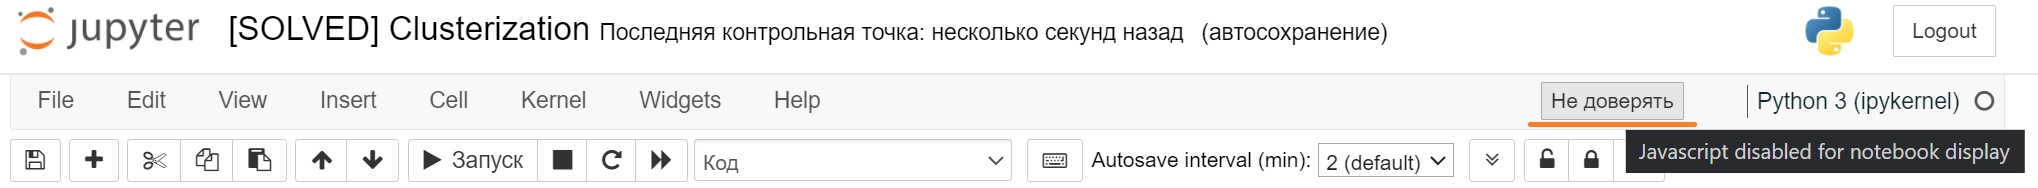

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

## Установка в Google Colab
Если вы используете Google Colab, то вам достаточно установить библиотеки с помощью ячейки ниже. 

После установки нужных версий нажмите на кнопку `Restart runtime`, которая появится в следующей ячейке после завершения ее выполнения.

После перезапуска (`Restart runtime`) устанавливать библиотеки еще раз не нужно, достаточно проверить, что установилась их новая версия.

**Важно!** 
Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

**Обратите внимание, что установка `torch` и `tensorflow` через `pip` может сломать ваше окружение, особенно если вы используете GPU. Выполняйте их установку в соответствии с Вашей конфигурацией системы или в отдельном виртуальном окружении**

Внимание! Ячейка перезапускает рантайм для учета обновления библиотек!

Тот же файл ссылкой: https://drive.google.com/file/d/1emagLwrQrZoaitHvoRkp2ZOFNg0TsZdR/view?usp=share_link

In [ ]:
!pip install --upgrade --no-cache-dir gdown 
!gdown 1emagLwrQrZoaitHvoRkp2ZOFNg0TsZdR

!pip install -r /content/requirements2.txt

if 'google.colab' in str(get_ipython()):
    import IPython, ipywidgets, google

    button = ipywidgets.Button(
        description='Нажмите, чтобы перезапустить Google Colab Runtime',
        layout=ipywidgets.Layout(width='auto', height='40px')
    )        
    button.on_click(lambda _: get_ipython().kernel.do_shutdown(True))
    IPython.display.display(button)

In [ ]:
import matplotlib
assert(matplotlib.__version__ == '3.5.3')

# 0. Введение.

## 0.1 О задании

В данной работе вам будет предложено применить кластеризацию и снижение размерности в задачах **Частичного Обучения** (Semi-Supervised learning).

## 0.2 Необходимые библиотеки

Здесь перечислены основные функции и библиотеки, которые могут понадобиться Вам в процессе выполнения задания. Подключение других библиотек возможно, но нежелательно. **Работа каких-либо других библиотек не гарантируется.**

In [2]:
import warnings

import numpy as np

import tqdm.auto as tqdm

import scipy.spatial.distance

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from torchvision.datasets import MNIST

import sklearn

from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier

# Библиотека umap-learn, а не umap
from umap import UMAP

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

2023-04-25 18:07:29.829055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 18:07:30.742849: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-25 18:07:30.742961: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-25 18:07:30.742967: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

**Обратите внимание, что динамическое содержимое может некорректно сохраняться в jupyter notebook. Используйте его только для локальной визуализации. Все графики, необходимые для сдачи задания должны быть статическими. Переход в статический режим происходит с помощью магической команды `%matplotlib inline`.**

**<font color=red>Обязательно убедитесь, что все графики корректно отображаются после сдачи в систему.</font>** Для этого достаточно открыть загруженный в систему файл и, просмотрев его, убедиться, что все сохранилось корректно

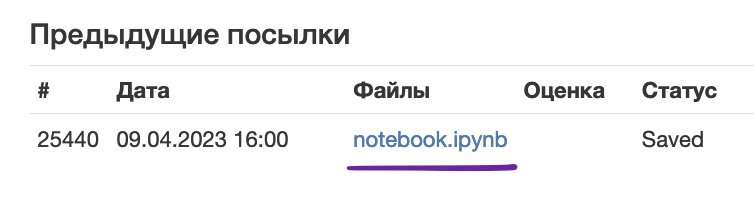

In [3]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 300

## 0.3 Ещё несколько важных замечаний

При выполнении задания <font color='red'>запрещено</font>:
1. Менять те seed, которые явно указаны в коде
2. Менять прототипы функций, классов, методов классов
3. Менять константы, используемые для генерации выборок

При оформлении задания обратите внимание на форматирование кода и на оформление графиков:

* Весь код должен быть оформлен в строгом соответствии с [PEP8](https://pep8.org/) (для юнит-тестов обязательно, для ноутбука очень желательно)

Графики должны быть с одной стороны понятными и информативными, а с другой стороны *красивыми*. Вот несколько пунктов, которые помогут удовлетворить этим требования:
1. Все графики должны быть отрисованы в **векторном формате**. Обратите внимание, что смена режима графиков с динамического на статический и обратно может приводить к сбросу параметров отрисовки графиков. Переход в векторный режим можно выполнить с помощью команды `matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')`. Если изображения в векторном формате приводят к слишком большому размеру Jupyter Notebook можете использовать растровые изображения с **высоким dpi**. Напирмер, можно установить глобальный dpi в matplotlib: `matplotlib.rcParams['figure.dpi'] = 300`
2. На всех графиках без исключения должна быть нарисована сетка
3. Все графики и группы графиков должны иметь заголовок (`title`)
4. При необходимости оси должны быть подписаны
5. Если на графике отображено несколько сущностей (линии/точки/bar разных цветов, формы и так далее), то необходима исчерпывающая легенда
6. Все линии на графиках должны быть чётко видны (нет похожих цветов или цветов, сливающихся с фоном и так далее)
7. Масштаб по каждой оси на графике должен быть выбран правильно. Используйте масштабы `log`, `symlog` по необходимости
8. Если отображена величина, имеющая очевидный диапазон значений (например, проценты могут быть от 0 до 100), то желательно масштабировать ось на весь диапазон значений (исключением является случай, когда вам необходимо показать малое отличие, которое незаметно в таких масштабах)
9. Частота отметок по каждой оси должна быть тщательно подобрана, по необходимости задавайте `[xy]ticks`, `[xy]ticklabels` вручную. Подписи тиков на осях не должны сливаться как на одной оси, так и между ними
10. Помните, что matplotlib умеет выполнять [рендеринг Latex](https://matplotlib.org/stable/gallery/text_labels_and_annotations/tex_demo.html). Используйте эту возможность для написания формул в заголовках, легенде и в подписях осей
11. Используйте *красивую* цветовую палитру с хорошо различимыми цветами. Примеры цветовых палитр можно посмотреть [здесь](https://matplotlib.org/stable/gallery/color/colormap_reference.html). При наличи особенностей восприятия цвета можно использовать специальные палитры:
```python
plt.style.use('seaborn-colorblind')
# Или
plt.style.use('tableau-colorblind10')
# Затем, при отрисовке графиков не используйте параметр cmap
```
12. Графики должны быть не супер-микро и не супер-макро по размерам, так, чтобы можно было увидеть все, что нужно

# 1. Частичное обучение.  [кросспроверка 10 баллов,  unittests 10 баллов]

В этой части мы рассмотрим применение алгоритмов снижения размерности и кластеризации в контексте задач классификации в постановке Semi-Supervised learning.

Рассмотрим задачу классификации изображений из датасета MNIST. Предположим, что известна только небольшая часть разметки по которой мы хотим обучить классификатор. В отличии от классических задач обучения с учителем здесь мы можем использовать большой объём неразмеченных объектов.

Будем далее считать, что неразмеченные объекты имеют метку $-1$.

Существует много вариантов решения данной задачи. Предлагается рассмотреть следующие из них:
1. Обучение модели, например, логистической регрессии на размеченной части
2. Методы SelfTraining, в частости `SelfTrainingClassifier` с логистической регрессией в качестве базовой модели
3. Использование кластеризации для определения групп похожих объектов и размеченной подвыборки для определения меток кластеров

Каждый из данных вариантов можно обучать на разных признаковых пространствах. Предлагается проверить, как методы снижения размерности будут влиять на качество итогового алгоритма. Нужно учесть, что не все алгоритмы снижения размерности допускают преобразование новых объектов в низкоразмерное пространство, поэтому предлагается сравнить `UMAP` с исходным признаковым пространством.

#### **Задание 1.1 [unittests, 10 баллов]** 

Реализуйте третью из предложенных моделей. Подробная спецификация и описание входных данных к тестам указаны в **описании задания (pdf)**.

**Замечание:** В данном пункте разрешено использовать `sklearn.cluster.KMeans`

In [3]:
class KMeansClassifier(sklearn.base.BaseEstimator):
    def __init__(self, n_clusters):
        '''
        :param int n_clusters: Число кластеров которых нужно выделить в обучающей выборке с помощью алгоритма кластеризации
        '''
        super().__init__()
        self.n_clusters = n_clusters
        self.model = KMeans(n_clusters=n_clusters, random_state=42)

    def fit(self, data, labels):
        '''
            Функция обучает кластеризатор KMeans с заданным числом кластеров, а затем с помощью
        self._best_fit_classification восстанавливает разметку объектов

        :param np.ndarray data: Непустой двумерный массив векторов-признаков объектов обучающей выборки
        :param np.ndarray labels: Непустой одномерный массив. Разметка обучающей выборки. Неразмеченные объекты имеют метку -1.
            Размеченные объекты могут иметь произвольную неотрицательную метку. Существует хотя бы один размеченный объект
        :return KMeansClassifier
        '''
        self.model.fit(data)
        cluster_labels = self.model.predict(data)
        self.mapping, _ = self._best_fit_classification(cluster_labels, labels)

        return self

    def predict(self, data):
        '''
        Функция выполняет предсказание меток класса для объектов, поданных на вход. Предсказание происходит в два этапа
            1. Определение меток кластеров для новых объектов
            2. Преобразование меток кластеров в метки классов с помощью выученного преобразования

        :param np.ndarray data: Непустой двумерный массив векторов-признаков объектов
        :return np.ndarray: Предсказанные метки класса
        '''
        cluster_labels = self.model.predict(data)
        predictions = self.mapping[cluster_labels]

        return predictions

    def _best_fit_classification(self, cluster_labels, true_labels):
        '''
        :param np.ndarray cluster_labels: Непустой одномерный массив. Предсказанные метки кластеров.
            Содержит элементы в диапазоне [0, ..., n_clusters - 1]
        :param np.ndarray true_labels: Непустой одномерный массив. Частичная разметка выборки.
            Неразмеченные объекты имеют метку -1. Размеченные объекты могут иметь произвольную неотрицательную метку.
            Существует хотя бы один размеченный объект
        :return
            np.ndarray mapping: Соответствие между номерами кластеров и номерами классов в выборке,
                то есть mapping[idx] -- номер класса для кластера idx
            np.ndarray predicted_labels: Предсказанные в соответствии с mapping метки объектов

            Соответствие между номером кластера и меткой класса определяется как номер класса с максимальным числом объектов
        внутри этого кластера.
            * Если есть несколько классов с числом объектов, равным максимальному, то выбирается метка с наименьшим номером.
            * Если кластер не содержит размеченных объектов, то выбирается номер класса с максимальным числом элементов в выборке.
            * Если же и таких классов несколько, то также выбирается класс с наименьшим номером
        '''
        mapping = np.zeros(self.n_clusters)

        cls_idxs, cls_counts = np.unique(true_labels[true_labels != -1], return_counts=True)
        mst_freq_cls = cls_idxs[np.argmax(cls_counts)]

        for cluster_num in np.arange(self.n_clusters):
            tr_label_clust = true_labels[cluster_labels == cluster_num]
            tr_label_clust_uniq, tr_label_clust_cnt = np.unique(tr_label_clust[tr_label_clust != -1], return_counts=True)
            mapping[cluster_num] = tr_label_clust_uniq[np.argmax(tr_label_clust_cnt)] if tr_label_clust_uniq.size != 0 else mst_freq_cls

        return mapping, mapping[cluster_labels]

Проверьте `KMeansClassifier._best_fit_classification` на простейших тестах:

In [4]:
def all_equal(list_left, list_right):
    assert np.all([np.all(left == right) for left, right in zip(list_left, list_right)])

all_equal(
    KMeansClassifier(10)._best_fit_classification(
        np.array([2, 2, 2, 1, 1, 1, 0, 0, 0]),
        np.array([5, 5, 6, 8, 7, 6, 6, 7, 7]),
    ),
    (np.array([7, 6, 5, 6, 6, 6, 6, 6, 6, 6]), np.array([5, 5, 5, 6, 6, 6, 7, 7, 7]))
)

all_equal(
    KMeansClassifier(10)._best_fit_classification(
        np.array([ 4,  4,  4, 1, 1, 1, 2, 2, 2, 3, 3, 3,  0, 0,  0, 0,  0]),
        np.array([-1, -1, -1, 5, 5, 6, 8, 7, 6, 6, 7, 7, -1, 8, -1, 3, -1]),
    ),
    (np.array([3, 5, 6, 7, 6, 6, 6, 6, 6, 6]), np.array([6, 6, 6, 5, 5, 5, 6, 6, 6, 7, 7, 7, 3, 3, 3, 3, 3]))
)

Теперь создадим модель которая будет объединять все вышеописанные способы решения задачи Semi-Supervised learning.

#### **Задание 1.2 [код]** 

Реализуйте модель, которая в зависимости от параметра `data_processing` будет выполнять то или иное преобразование признакового пространства. Параметр `model` должен задавать одну из трёх описанных выше моделей поверх преобразованных данных. Вспомогательные аргументы нужно передавать через словари `reducer_kwargs`, `model_kwargs` (например, размерность пространства для методов снижения размерности, коэффициент регуляризации логистической регрессии, число кластеров KMeans и так далее).

*Замечание:* Большую часть времени работы модели (как обучения, как и предсказания) будет занимать преобразование признаков в низкоразмерное пространство с помощью UMAP. Если несколько способов, как ускорить данный процесс:
1. Параметр `n_neighbors` у UMAP значительно влияет на скорость работы. Можно установить его меньше, чем по умолчанию (не желательно ставить его меньше $5-7$). Попробуйте подобрать этот параметр в зависимости от качества визуализации в задании **1.3**
2. Так как UMAP метрический алгоритм, он требует большого числа вычислений попарных расстояний между точками. При выполнении перебора гиперпараметров в заданиях ниже можно значительно сэкономить, предподсчитав попарное расстояние между объектами для обучения и расстояние между объектам для предсказаний и объектами обучающей выборки. Используйте для работы в таком режиме `metric='precomputed'`. В таком режиме UMAP выдаёт ненужные warnings. Подавите их с помощью соответствующего контекст менеджера:
```python
with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Вызовы UMAP. __init__ / fit / fit_transform / transform
```
Не забудьте про масштабирование признаков

In [5]:
class MetaSemiSupervisedModel(sklearn.base.BaseEstimator):
    def __init__(self, data_processing=None, model='LogisticRegression', reducer_kwargs=None, model_kwargs=None):
        '''
        :param str data_processing: 
            Если data_processing == 'UMAP', то входные данные необходимо преобразовать с помощью данного алгоритма с
                числом компонент reducer_kwargs['n_components'].
            Опционально, используйте reducer_kwargs['metric'] для ускорения алгоритма с помощью предподсчитанной
                матрицы расстояний 
            Иначе, не преобразовывать входные данные
        :param str model:
            Если model == 'LogisticRegression', то использовать логистическую регрессию на размеченных данных
                и коэффициентом регуляризации model_kwargs['C']
            Если model == 'SelfTrainingClassifier', то использовать SelfTrainingClassifier с базовой моделью LogisticRegression
                и коэффициентом регуляризации model_kwargs['C']
            Если model == 'KMeansClassifier', то использовать KMeansClassifier с числом кластеров model_kwargs['n_clusters']
        :param dict reducer_kwargs:
        :param dict model_kwargs:
        '''
        super().__init__()

        self.model_name = model
        self.data_processing = None
        self.metric = None
        self.scaler = StandardScaler()
        
        if model == 'LogisticRegression':
            self.model = LogisticRegression(C=model_kwargs['C'])
        elif model == 'SelfTrainingClassifier':
            self.model = SelfTrainingClassifier(base_estimator=LogisticRegression(C=model_kwargs['C']))
        elif model == 'KMeansClassifier':
            self.model = KMeansClassifier(n_clusters=model_kwargs['n_clusters'])
        else:
            raise "Wrong model"

        if data_processing == "UMAP":
            self.metric = reducer_kwargs.get('metric', 'euclidean')
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                self.data_processing = UMAP(n_components=reducer_kwargs['n_components'], metric=self.metric, n_neighbors=8, random_state=42)

    def fit(self, data, labels):
        '''
        :param np.ndarray data: Непустой двумерный массив векторов-признаков объектов обучающей выборки. 
            Если reducer_kwargs['metric'] == 'precomputed', тогда @data квадратная матрица попарных расстояний между объектами
        :param np.ndarray labels: Непустой одномерный массив. Разметка обучающей выборки. Неразмеченные объекты имеют метку -1. 
            Размеченные объекты могут иметь произвольную неотрицательную метку. Существует хотя бы один размеченный объект
        :return MetaSemiSupervisedModel
        '''
        processed_data = data
        if self.metric != 'precomputed':     # не нормализуем если это матрица попарных расстояний
            self.scaler.fit(processed_data)
            processed_data = self.scaler.transform(processed_data)
        if self.data_processing is not None:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                self.data_processing.fit(processed_data)
                processed_data = self.data_processing.transform(processed_data)
        if self.model_name == "LogisticRegression":
            processed_data = processed_data[labels != -1]
            labels = labels[labels != -1]

        self.model.fit(processed_data, labels)

        return self

    def predict(self, data):
        '''
        Функция выполняет предсказание меток класса для объектов, поданных на вход
        :param np.ndarray data: Непустой двумерный массив векторов-признаков объектов.
            Если reducer_kwargs['metric'] == 'precomputed', тогда @data прямоугольная матрица расстояний между
            каждым объектом для которого делается предсказание и каждым объектом обучающей выборки.
        :return np.ndarray: Предсказанные метки класса
        '''
        processed_data = data
        if self.metric != 'precomputed':
            processed_data = self.scaler.transform(processed_data)
        if self.data_processing is not None:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                processed_data = self.data_processing.transform(processed_data)

        predictions = self.model.predict(processed_data)

        return predictions

Загрузим датасет MNIST. Для ускорения перебора гиперпараметров, можете уменьшить число объектов в выборке. Не делайте это число менее $4000$.

In [6]:
mnist_n_objects = 4000

In [7]:
mnist_test_dataset = MNIST('./mnist', train=False, download=True)
mnist_train_dataset = MNIST('./mnist', train=True, download=False)

mnist_labels_test = np.array(mnist_test_dataset.targets)
mnist_labels_train = np.array(mnist_train_dataset.targets)

mnist_images_test = mnist_test_dataset.data.numpy()
mnist_images_train = mnist_train_dataset.data.numpy()

mnist_images_test, _, mnist_labels_test, _ = train_test_split(
    mnist_images_test, mnist_labels_test, 
    train_size=mnist_n_objects, stratify=mnist_labels_test, random_state=6886
)
mnist_images_train, _, mnist_labels_train, _ = train_test_split(
    mnist_images_train, mnist_labels_train,
    train_size=mnist_n_objects, stratify=mnist_labels_train, random_state=6886
)

mnist_data_test = (mnist_images_test.astype(np.float32) / 255.0).reshape([mnist_images_test.shape[0], -1])
mnist_data_train = (mnist_images_train.astype(np.float32) / 255.0).reshape([mnist_images_train.shape[0], -1])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



#### **Задание 1.3 [код]** 

Примените метод снижения размерности на ваш вкус для новых данных и изобразите результат на графике. Используйте это представление для визуализации в дальнейшем.

*Замечание:* Не забудьте, что масштаб признаков существенно влияет на работу алгоритма снижения размерности.

*Замечание:* Для отрисовки низкоразмерных данных можно использовать функцию `plot_interactive`. Данная функция может работать и в интерактивном режиме, которым можно воспользоваться, если ваша среда выполнения его поддерживает. Не забудьте переключиться в статический режим после отрисовки динамического контента с помощью магической команды `%matplotlib inline`.

In [8]:
def plot_interactive(lowd_data, images, labels, names, n_dots=1000, image_scale=1.0):
    with matplotlib.rc_context(rc={
        'font.size': image_scale * matplotlib.rcParams['font.size'],
        'xtick.major.size': image_scale * matplotlib.rcParams['xtick.major.size'],
        'xtick.minor.size': image_scale * matplotlib.rcParams['xtick.minor.size'],
        'ytick.major.size': image_scale * matplotlib.rcParams['ytick.major.size'],
        'ytick.minor.size': image_scale * matplotlib.rcParams['ytick.minor.size'],

        'axes.linewidth': image_scale * matplotlib.rcParams['axes.linewidth'],
        'grid.linewidth': image_scale * matplotlib.rcParams['grid.linewidth'],
        'patch.linewidth': image_scale * matplotlib.rcParams['patch.linewidth'],
        'xtick.major.width': image_scale * matplotlib.rcParams['xtick.major.width'],
        'xtick.minor.width': image_scale * matplotlib.rcParams['xtick.minor.width'],
        'ytick.major.width': image_scale * matplotlib.rcParams['ytick.major.width'],
        'ytick.minor.width': image_scale * matplotlib.rcParams['ytick.minor.width'],

        'lines.markeredgewidth': image_scale * matplotlib.rcParams['lines.markeredgewidth'],
    }):
        fig, ax = plt.subplots(1, 1, figsize=(image_scale * 10, image_scale * 5))
        fig.set_dpi(300)
        ax.grid(True)

        n_clusters = len(np.unique(labels))

        scatter = plt.scatter(
            lowd_data[:n_dots, 0], lowd_data[:n_dots, 1], s=image_scale * 10, 
            c=labels[:n_dots], cmap=plt.get_cmap('tab20', n_clusters), edgecolors='none'
        )

        cbar = plt.colorbar(scatter, ax=ax, label='Название кластера')
        cbar.set_ticks(np.min(labels[:n_dots]) + (np.arange(n_clusters) + 0.5) * (n_clusters - 1) / n_clusters)
        cbar.set_ticklabels(names)

        offset_image = OffsetImage(images[0], zoom=image_scale * 2.0)
        ann_bbox = AnnotationBbox(
            offset_image, (0,0), xybox=(image_scale * 50., image_scale * 50.), xycoords='data',
            boxcoords="offset points", pad=0.3, arrowprops=dict(
                arrowstyle='->, head_length={0:.2f}, head_width={1:.2f}'.format(
                    image_scale * 0.4, image_scale * 0.2
                )
            )
        )
        ax.add_artist(ann_bbox)
        ax.set_title('Распределение данных CIFAR10 в проекции на 2 случайные оси', fontsize=8)
        ann_bbox.set_visible(False)

        def image_hover(event):
            if scatter.contains(event)[0]:
                ind, *_ = scatter.contains(event)[1]["ind"]
                w, h = fig.get_size_inches() * fig.dpi
                ws = (event.x > w / 2.) * -1 + (event.x <= w / 2.) 
                hs = (event.y > h / 2.) * -1 + (event.y <= h / 2.)
                ann_bbox.xybox = (image_scale * 50.0 * ws, image_scale * 50.0 * hs)
                ann_bbox.set_visible(True)
                ann_bbox.xy =(lowd_data[ind, 0], lowd_data[ind, 1])
                offset_image.set_data(images[ind])
            else:
                ann_bbox.set_visible(False)
            fig.canvas.draw_idle()

        fig.canvas.mpl_connect('motion_notify_event', image_hover) 

        plt.show()

In [9]:
%matplotlib ipympl
matplotlib.rcParams['figure.dpi'] = 300

# Для работы в Google Colab нужно выполнить специфичную магию
# Обычно, она не срабатывает с первого раза, поэтому может потребоваться
#   несколько раз выполнить ячейку и несколько раз попробовать нарисовать график
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    pass

In [35]:
plt.style.use("seaborn")

In [19]:
scaler = StandardScaler().fit(mnist_data_train)
reducer = UMAP(n_neighbors=15).fit(scaler.transform(mnist_data_train))

In [20]:
lowd_mnist_data_test = reducer.transform(scaler.transform(mnist_data_test))

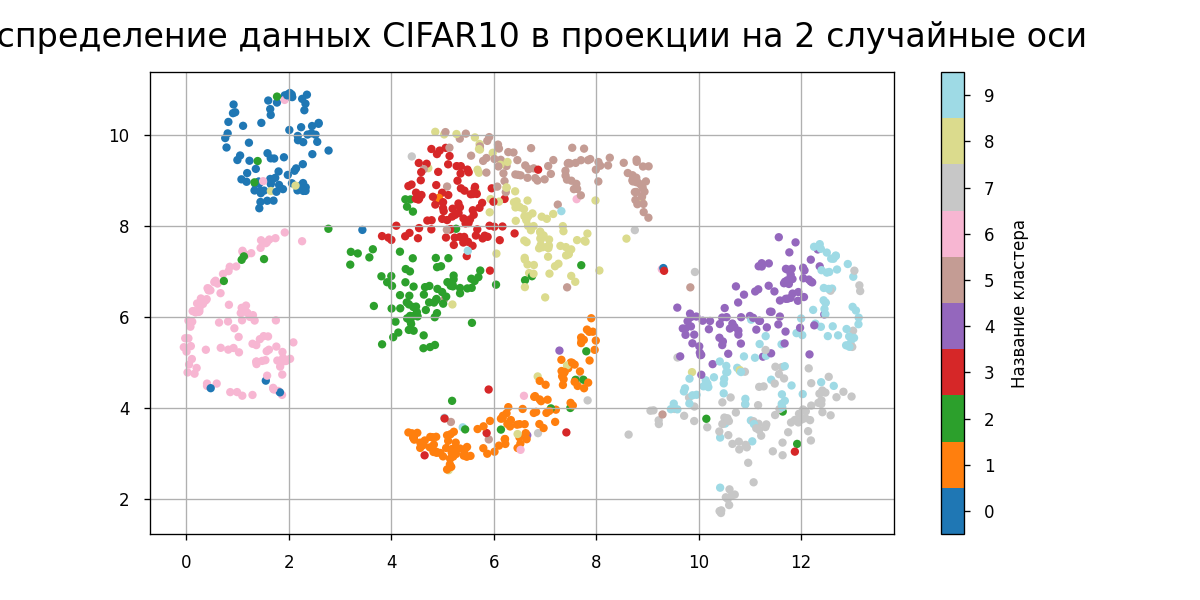

In [21]:
plot_interactive(lowd_mnist_data_test, mnist_images_test, mnist_labels_test, names=np.arange(10), image_scale=0.4)

Вернёмся в статичный режим отрисовки изображений:

In [22]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 300

#### **Задание 1.4 [код]** 

Разбейте выборку следующим образом:
1. Разбейте случайным образом обучающую выборку на 2 части — размеченную и неразмеченную. Считайте, что доля размеченных объектов — `fraction_of_labeled`. Метки неразмеченной части замените на $-1$.
2. Тестовую выборку разбейте в соотношении $30$ на $70$ — меньшую часть (далее будет называться **валидационной выборкой**) используйте для подбора гиперпараметров, а большую (**тестовая выборка**) для итоговой оценки качества.

In [23]:
fraction_of_labeled = 0.01

In [24]:
X_train_unlabeled, X_train_labeled, y_train_unlabeled, y_train_labeled = train_test_split(mnist_data_train, 
                                                                                          mnist_labels_train, 
                                                                                          test_size=fraction_of_labeled, 
                                                                                          random_state=42)
y_train_unlabeled[:] = -1

In [25]:
X_train, y_train = np.concatenate([X_train_unlabeled, X_train_labeled]), np.concatenate([y_train_unlabeled, y_train_labeled])

In [26]:
X_valid, X_test, y_valid, y_test = train_test_split(mnist_data_test, mnist_labels_test, test_size=0.7, random_state=42)

#### **Задание 1.5 [кросспроверка, 3 балла][код]** 

Используя MetaSemiSupervisedModel подберите оптимальные параметры:

* `C` — не менее $15$ точек в диапазоне $5-6$ десятичных порядков
* `n_clusters` — не менее $10$ точек вплоть до $100$
* `n_components` — не менее $7$ точек вплоть до $100$

для следующих моделей:
1. Исходные признаки + `LogisticRegression`
2. Исходные признаки + `SelfTrainingClassifier`
3. Исходные признаки + `KMeansClassifier`
4. `UMAP` + `LogisticRegression`
5. `UMAP` + `SelfTrainingClassifier`
6. `UMAP` + `KMeansClassifier`

Подбор каждого гиперпараметра должен быть сопровождён графиками точности на тестовой и валидационной выборках. Изобразите обе линии на одном графике.

При переборе **обязательно выводите значение найденного оптимального параметра и качество модели с оптимальным гиперпараметром** на выборке для итоговой оценки качества.

В последних трёх моделях используйте гиперпараметры базовых моделей, найденные в первых трёх моделях.

In [27]:
from sklearn.metrics import accuracy_score

In [38]:
## Определим сетки перебора параметров для каждой модели
param_grid = {'LogisticRegression'    : {'C'         : np.logspace(-6, 2, 15)},
              'SelfTrainingClassifier': {'C'         : np.logspace(-6, 2, 15)},
              'KMeansClassifier'      : {'n_clusters': np.linspace(1, 100, 11, dtype=int)},
              'UmapLogisticRegression'    : {'n_components': np.linspace(2, 100, 11, dtype=int)},
              'UmapSelfTrainingClassifier': {'n_components': np.linspace(2, 200, 11, dtype=int)},
              'UmapKMeansClassifier'      : {'n_components': np.linspace(2, 200, 11, dtype=int)}}

In [39]:
## Сюда положим результаты прогонов
results = {'LogisticRegression'    : {'valid': [], 'test': []},
           'SelfTrainingClassifier': {'valid': [], 'test': []},
           'KMeansClassifier'      : {'valid': [], 'test': []},
           'UmapLogisticRegression'    : {'valid': [], 'test': []},
           'UmapSelfTrainingClassifier': {'valid': [], 'test': []},
           'UmapKMeansClassifier'      : {'valid': [], 'test': []}}

In [40]:
## Здесь будут оптимальные параметры
optimal_params = {'LogisticRegression'    : {}, 
                  'SelfTrainingClassifier': {}, 
                  'KMeansClassifier'      : {},
                  'UmapLogisticRegression'    : {'metric': 'precomputed'}, 
                  'UmapSelfTrainingClassifier': {'metric': 'precomputed'}, 
                  'UmapKMeansClassifier'      : {'metric': 'precomputed'}}

In [41]:
## Перебор для первых 3-ех моделей
for model_name in ['LogisticRegression', 'SelfTrainingClassifier', 'KMeansClassifier']:
    param_range = param_grid[model_name]
    param_name = list(param_range)[0]
    for param_val in param_range[param_name]:
        model = MetaSemiSupervisedModel(model=model_name,
                                        model_kwargs={param_name: param_val}
                                       ).fit(X_train, y_train)
        
        results[model_name]['valid'].append(accuracy_score(y_valid, model.predict(X_valid)))
        results[model_name]['test'].append(accuracy_score(y_test, model.predict(X_test)))

In [42]:
%config InlineBackend.figure_format = 'svg'

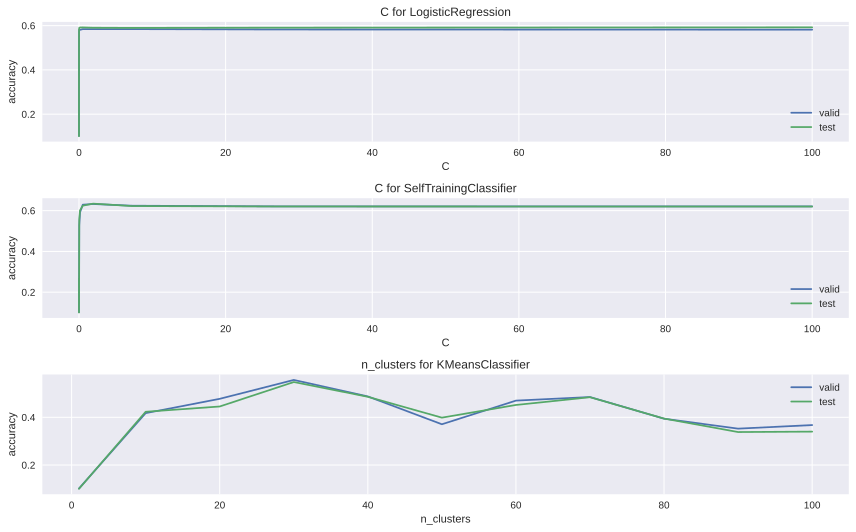

In [43]:
fig, ax = plt.subplots(3)
fig.set_size_inches(12, 7.5)
for i, model in enumerate(['LogisticRegression', 'SelfTrainingClassifier', 'KMeansClassifier']):
    param_range = param_grid[model]
    param_name = list(param_range)[0]
    param_range = param_range[param_name]
    ax[i].set_title(f'{param_name} for {model}')
    ax[i].plot(param_range, results[model]['valid'], label='valid')
    ax[i].plot(param_range, results[model]['test'], label='test')
    ax[i].set_ylabel('accuracy')
    ax[i].set_xlabel(param_name)
    ax[i].legend()
plt.tight_layout()
plt.show()

In [44]:
## Найденные оптмальные гиперпараметры (найдем по валидационной выборке и оценим на тесте)
for i, model in enumerate(['LogisticRegression', 'SelfTrainingClassifier', 'KMeansClassifier']):
    param_range = param_grid[model]
    param_name = list(param_range)[0]
    param_range = param_range[param_name]

    best_model_idx = np.argmax(results[model]['valid'])
    optimal_params[model][param_name] = param_range[best_model_idx]
    acc_on_test = results[model]['test'][best_model_idx]

    print(f"Optimal {param_name} for {model}: {optimal_params[model][param_name]}")
    print(f"Test accurcay for optimal param: {acc_on_test}\n")

Optimal C for LogisticRegression: 0.5179474679231202
Test accurcay for optimal param: 0.5917857142857142

Optimal C for SelfTrainingClassifier: 1.9306977288832496
Test accurcay for optimal param: 0.6342857142857142

Optimal n_clusters for KMeansClassifier: 30
Test accurcay for optimal param: 0.5478571428571428



In [45]:
## Отдельно нормализуем данные и посчитаем попарные расстояния
from sklearn.metrics import pairwise_distances 
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

X_train_dist = pairwise_distances(X_train_scaled)
X_valid_dist = pairwise_distances(X_valid_scaled, X_train_scaled)
X_test_dist = pairwise_distances(X_test_scaled, X_train_scaled)

In [46]:
## Перебор для последних 3-ех моделей
for model_name in ['LogisticRegression', 'SelfTrainingClassifier', 'KMeansClassifier']:
    param_range = param_grid['Umap' + model_name]
    param_name = list(param_range)[0]
    for param_val in param_range[param_name]:
        model = MetaSemiSupervisedModel(data_processing='UMAP',
                                        model=model_name,
                                        model_kwargs=optimal_params[model_name],  # теперь обучаем с оптимальными параметрами
                                        reducer_kwargs={param_name: param_val, 'metric': 'precomputed'}
                                       ).fit(X_train_dist, y_train)
        
        results['Umap' + model_name]['valid'].append(accuracy_score(y_valid, model.predict(X_valid_dist)))
        results['Umap' + model_name]['test'].append(accuracy_score(y_test, model.predict(X_test_dist)))

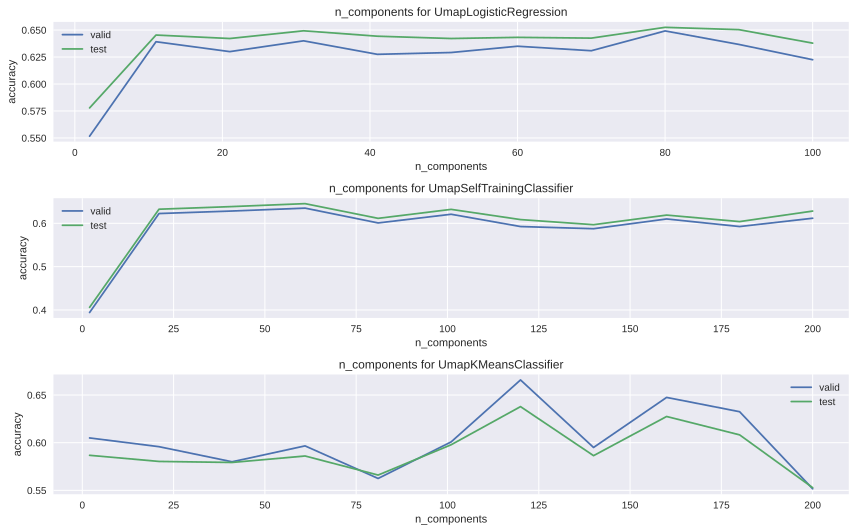

In [47]:
fig, ax = plt.subplots(3)
fig.set_size_inches(12, 7.5)
for i, model in enumerate(['LogisticRegression', 'SelfTrainingClassifier', 'KMeansClassifier']):
    param_range = param_grid['Umap' + model]
    param_name = list(param_range)[0]
    param_range = param_range[param_name]
    ax[i].set_title(f'{param_name} for {"Umap" + model}')
    ax[i].plot(param_range, results['Umap' + model]['valid'], label='valid')
    ax[i].plot(param_range, results['Umap' + model]['test'], label='test')
    ax[i].set_ylabel('accuracy')
    ax[i].set_xlabel(param_name)
    ax[i].legend()
plt.tight_layout()
plt.show()

In [48]:
## Найденные оптмальные гиперпараметры (найдем по валидационной выборке и оценим на тесте)
for i, model in enumerate(['LogisticRegression', 'SelfTrainingClassifier', 'KMeansClassifier']):
    param_range = param_grid['Umap' + model]
    param_name = list(param_range)[0]
    param_range = param_range[param_name]

    best_model_idx = np.argmax(results['Umap' + model]['valid'])
    optimal_params['Umap' + model][param_name] = param_range[best_model_idx]
    acc_on_test = results['Umap' + model]['test'][best_model_idx]
    
    print(f"Optimal {param_name} for {model}: {optimal_params['Umap' + model][param_name]}")
    print(f"Test accurcay for optimal param: {acc_on_test}\n")

Optimal n_components for LogisticRegression: 80
Test accurcay for optimal param: 0.6525

Optimal n_components for SelfTrainingClassifier: 61
Test accurcay for optimal param: 0.6453571428571429

Optimal n_components for KMeansClassifier: 120
Test accurcay for optimal param: 0.6378571428571429



In [49]:
optimal_params

{'LogisticRegression': {'C': 0.5179474679231202},
 'SelfTrainingClassifier': {'C': 1.9306977288832496},
 'KMeansClassifier': {'n_clusters': 30},
 'UmapLogisticRegression': {'metric': 'precomputed', 'n_components': 80},
 'UmapSelfTrainingClassifier': {'metric': 'precomputed', 'n_components': 61},
 'UmapKMeansClassifier': {'metric': 'precomputed', 'n_components': 120}}

#### **Задание 1.6 [кросспроверка, 3 балла][вопрос]** 

Опишите полученные результаты. Какая модель проявила себя лучше всего? Как влияет на результат снижение размерности признакового пространства?

*Ваш ответ здесь:*    

1. Сложно сказать, какя модель покалазала себя лучше всего. По итоговому качеству на тесте впереди оказалась модель Umap + LogistciRegression. При этом ее резульататы очень близки к Umap + KMeansClassifier и к SelfTrainingClassifier без UMAP. Так что можно сказать, что эти три модели примерно одинково хороши, особенно учитывая случайность. Но, даже с преподсчитанными матрицами попарных расстояний и с n_neighbours=8, обучение с UMAP занимает значительно больше времени. Так что из этих трех моделей я бы скорее всего выбрал SelfTrainingClassifier без UMAP.

2. Снижение размерности позволило улучшить качество для всех моделей.

#### **Задание 1.7 [кросспроверка, 2 балла][код]** 

Обучите каждую из шести моделей на выборках с разной долей размеченных объектов. Используйте оптимальные параметры из предыдущего пункта. Изобразите итоговое качество в зависимости от доли размеченных объектов для всех моделей на одном графике. 

Используйте сетку для перебора, указанную ниже. При желании можете взять больше точек.

In [55]:
fraction_of_labeled_range = [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 0.99]

In [51]:
end_res = {'LogisticRegression': [], 'SelfTrainingClassifier': [], 'KMeansClassifier': [],
           'UmapLogisticRegression': [], 'UmapSelfTrainingClassifier': [], 'UmapKMeansClassifier': []}

In [52]:
for fraction_of_labeled in fraction_of_labeled_range:
    X_train_unlabeled, X_train_labeled, y_train_unlabeled, y_train_labeled = train_test_split(mnist_data_train,
                                                                                              mnist_labels_train,
                                                                                              test_size=fraction_of_labeled,
                                                                                              random_state=42)
    y_train_unlabeled[:] = -1
    X_train, y_train = np.concatenate([X_train_unlabeled, X_train_labeled]), np.concatenate([y_train_unlabeled, y_train_labeled])

    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_dist = pairwise_distances(X_train_scaled)
    X_test_dist = pairwise_distances(X_test_scaled, X_train_scaled)

    for model_name in ['LogisticRegression', 'SelfTrainingClassifier', 'KMeansClassifier']:

        model = MetaSemiSupervisedModel(model=model_name,
                                        model_kwargs=optimal_params[model_name]
                                       ).fit(X_train, y_train)

        umap_model = MetaSemiSupervisedModel(model=model_name,
                                             data_processing='UMAP',
                                             model_kwargs=optimal_params[model_name],
                                             reducer_kwargs=optimal_params['Umap' + model_name]
                                            ).fit(X_train_dist, y_train)

        end_res[model_name].append(accuracy_score(y_test, model.predict(X_test)))
        end_res['Umap' + model_name].append(accuracy_score(y_test, umap_model.predict(X_test_dist)))


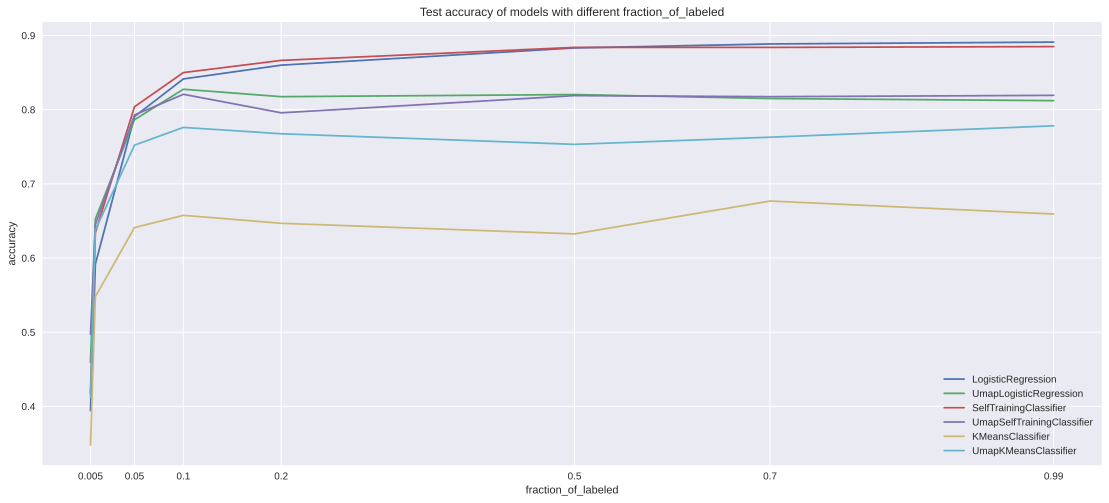

In [56]:
fig, ax = plt.subplots()
fig.set_size_inches(19, 8)

ax.set_title('Test accuracy of models with different fraction_of_labeled')
for i, model_name in enumerate(['LogisticRegression', 'SelfTrainingClassifier', 'KMeansClassifier']):
    ax.plot(fraction_of_labeled_range, end_res[model_name], label=model_name)
    ax.plot(fraction_of_labeled_range, end_res['Umap' + model_name], label='Umap' + model_name)
    
ax.legend()
fraction_of_labeled_range.remove(0.01)
ax.set_xticks(fraction_of_labeled_range, fraction_of_labeled_range)
ax.set_xlabel('fraction_of_labeled')
ax.set_ylabel('accuracy')
plt.show()

#### **Задание 1.8 [кросспроверка, 2 балла][вопрос]** 

Как разные модели ведут себя в зависимости от объёма размеченных данных? Какой размер выборки достаточно разметить, чтобы получить близкое к максимальному качество?

*Ваш ответ здесь:*    
    
Как разные модели ведут себя в зависимости от объёма размеченных данных:
      
1. Качество LogisticRegression с ростом объема размеченных данных монотонно растет. Это неудивительно, тк эта модель обучается *только* на размеченных данных - чем их больше, тем лучше.    

2. Качество UmapLogisticRegression сначала растет почти также, как LogisticRegression, но начиная с доли в 0.2 расти перестает. Скорее всего это связано с тем, что UMAP не лучшим образом выделяет признаки из изображений и с ростом числа объектов теряется слишком много полезной информации.    

3. SelfTrainingClassifier ведет себя также, как LogisticRegression, но за счет использования неразмеченной части выборки сначала растет быстрее. Когда доля размеченной выборки становится близка к 1, то модель начинает совпадать с LogisticRegression. Это неудивительно, тк базовой моделью для SelfTrainingClassifier как раз и является LogisticRegression. Когда почти вся выборка размечена, то выигрыша в Label Propagation практически нет, хотя и хуже не становится.    

4. UmapSelfTrainingClassifier ведет себя один в один как просто SelfTrainingClassifier, но перестает расти с доли в 0.2. Интересно, что UmapSelfTrainingClassifier при стремлении доли размеченных данных к 1, начинает совпадать с UmapLogisticRegression. Также как просто SelfTrainingClassifier и просто LogisticRegression    

5. KMeansClaffifier при совсем неболльшой доле размеченных данных близок к остальным моделям, но в основном проигрывает. То растет, то падает и лучшего качество досстигает при использовании 0.7 от всех меток, а не при 0.99. Это связано с тем, что в исходном признаковом пространстве (т.е. в пикселях), очень сложно кластеризовать объекты, особенно в предположении выпкулых округлых кластеров.    

6. UmapKMeansClaffifier гораздо лучше, чем без Umap. Опять же в начале наблюадется быстрый рост, на равне с другими моделями, но начиная с доли в 0.2 расти перестает. Скорее всего это связано с тем, что UMAP не лучшим образом выделяет признаки из изображений и с ростом числа объектов теряется слишком много полезной информации + сложная форма кластеров.

Какой размер выборки достаточно разметить, чтобы получить близкое к максимальному качество: [0.1 - 0.5] - До этого числа качество всех моделей растет.

Модели с UMAP выгодно использовать при небольшой доле размеченных данных.